 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations (Incomplete)

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (ie, as a vector of latent factors).
- Such vectros are inferred (ie, learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $R \in \mathbb R^{m \times n}$ with the product of a user latent factor matrix $X \in \mathbb R^{m \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times n}$. So

$$
R \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load the dataset
ratings = pd.read_csv("./data/Netflix_Dataset_Rating.csv")  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv("./data/Netflix_Dataset_Movie.csv")    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## User-Based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$ is the set of users.
  - $i \in I$ is the set of movies.
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed atings, the matrix $R$ is partially known and filled with those observations. To actully learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in, matrix notation, is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| R - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $R \in \mathbb{R}^{m \times n}$ is the observed rating matrix, with $R_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{m \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{n \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{R} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| R - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| R - X W^T \|_F^2 = -(R - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(R - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| R - X W^T \|_F^2 = -(R - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(R - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Setting up the model parameters

# Hyperparameters
num_factors = 100  # Number of latent factors (k)
learning_rate = 0.01  # Learning rate (eta)
reg_lambda = 0.1  # Regularization term (lambda)
num_epochs = 30  # Number of epochs
gradient_clip = 2.0  # Gradient clipping threshold

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Initialize latent factor matrices X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# Create a mask for observed entries in R
R = user_item_matrix.values
mask = R > 0  # Boolean mask for observed entries

# List to store loss values for plotting
loss_history = []

### 3. Optimize the Loss Function with Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

#### Explanation of the SGD Algorithm (Matrix Form)

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{R} = X W^T
  $$
- Compute the error matrix (only for observed entries in $R$):
  $$
  E = \begin{cases}
  R_{ui} > 0 \quad R_{ui} - \hat{R}_{ui}\\
  0 \quad \text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $R$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| R - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $R$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [7]:
#4. Start SGD loop

# Initialize R_hat as the predicted matrix
R_hat = np.ndarray(shape=(num_users, num_items))

# Perform SGD for a number of epochs

for epoch in range(num_epochs):
    # Compute the predicted matrix
    R_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, R - R_hat)

    # Compute gradients with regularization
    grad_X = -E @ W + reg_lambda * X
    grad_W = -E.T @ X + reg_lambda * W

    # Apply gradient clipping to avoid exploding updates
    grad_X = np.clip(grad_X, -gradient_clip, gradient_clip)
    grad_W = np.clip(grad_W, -gradient_clip, gradient_clip)

    # Update X and W
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Check for NaN or Inf values in X or W
    if np.any(np.isnan(X)) or np.any(np.isnan(W)) or np.any(np.isinf(X)) or np.any(np.isinf(W)):
        print("Numerical instability detected. Terminating training.")
        break

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

Epoch 1/30
  Reconstruction Loss: 243096336.8193
  Regularization Loss: 173.5566
  Total Loss: 243096510.3759
  Gradient X: mean=0.0138, std=0.4234
  Gradient W: mean=0.0188, std=1.5754
Epoch 2/30
  Reconstruction Loss: 243025143.4859
  Regularization Loss: 608.8258
  Total Loss: 243025752.3117
  Gradient X: mean=-0.0392, std=1.6836
  Gradient W: mean=0.0388, std=1.9757
Epoch 3/30
  Reconstruction Loss: 240346544.7414
  Regularization Loss: 1459.0490
  Total Loss: 240348003.7904
  Gradient X: mean=0.1167, std=1.9251
  Gradient W: mean=0.0283, std=1.9979
Epoch 4/30
  Reconstruction Loss: 231143324.2500
  Regularization Loss: 3232.8502
  Total Loss: 231146557.1002
  Gradient X: mean=0.0463, std=1.9037
  Gradient W: mean=0.2535, std=1.9813
Epoch 5/30
  Reconstruction Loss: 216493572.6411
  Regularization Loss: 5783.1455
  Total Loss: 216499355.7866
  Gradient X: mean=0.2463, std=1.9535
  Gradient W: mean=0.0878, std=1.9973
Epoch 6/30
  Reconstruction Loss: 195127498.2908
  Regularization 

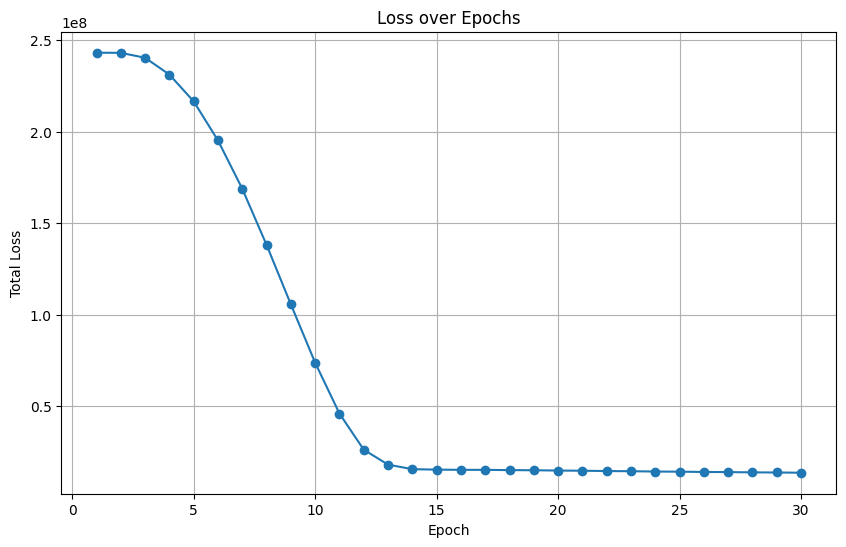

In [8]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.show()

In [6]:
def recommend_movies(user_id, R_hat, user_item_matrix, movies, top_n=10):
    """
    Recommends movies for a given user based on the predicted matrix R_hat.

    Parameters:
    - user_id: ID of the user to whom the recommendations will be made.
    - R_hat: Predicted user-item matrix (num_users x num_items).
    - user_item_matrix: Original user-item matrix (Pandas DataFrame) with ratings.
    - movies: DataFrame containing movie details (Movie_ID, Name, Year).
    - top_n: Number of recommendations to return (default is 10).

    Returns:
    - recommendations: DataFrame containing the top_n recommended movies.
    """
    # Map user_id to the corresponding index in R_hat
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    predicted_ratings = R_hat[user_index]

    # Get the user's original ratings
    original_ratings = user_item_matrix.loc[user_id]

    # Find movies that the user has not rated (those with a rating of 0)
    unrated_movies = original_ratings[original_ratings == 0].index

    # Map the unrated movies to the correct columns in R_hat
    unrated_predictions = {
        movie_id: predicted_ratings[user_item_matrix.columns.get_loc(movie_id)]
        for movie_id in unrated_movies
    }

    # Sort the predicted ratings for unrated movies in descending order
    sorted_predictions = sorted(unrated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Get the top_n movie IDs
    top_movie_ids = [movie_id for movie_id, _ in sorted_predictions[:top_n]]

    # Retrieve movie details for the top_n recommendations
    recommendations = movies[movies['Movie_ID'].isin(top_movie_ids)]

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    recommendations = recommendations.copy()
    
    # Add the Predicted_Rating column
    recommendations['Predicted_Rating'] = [unrated_predictions[movie_id] for movie_id in recommendations['Movie_ID']]
    
    # Sort recommendations by predicted rating (optional, for clarity)
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations[['Movie_ID', 'Name', 'Year', 'Predicted_Rating']]

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [13]:
# Step 4: Test the recommendation function
user_id_to_test = 774868  # Cambia con un ID utente valido nel dataset
num_recommendations = 5   # Numero di raccomandazioni desiderate

try:
    # Esegui la funzione di raccomandazione
    recommendations = recommend_movies(user_id_to_test, R_hat, user_item_matrix, movies, top_n=num_recommendations)
    
    # Mostra i risultati
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(recommendations[['Name', 'Year', 'Predicted_Rating', 'Movie_ID']])
except KeyError as e:
    print(f"Error: User ID {user_id_to_test} not found in the dataset.")
except ValueError as e:
    print(f"Error: {e}")

Top 5 movie recommendations for User 774868:
                                       Name  Year  Predicted_Rating  Movie_ID
2113                                Firefly  2002          5.917396      2114
3045      The Simpsons: Treehouse of Horror  1990          5.825943      3046
3443  Family Guy: Freakin' Sweet Collection  2004          5.824890      3444
4237                              Inu-Yasha  2000          5.817704      4238
2056     Buffy the Vampire Slayer: Season 6  2001          5.816484      2057


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Function to split the user-item matrix into train and test sets
def train_test_split_matrix(user_item_matrix, test_size=0.2, random_state=42):
    """
    Splits the user-item matrix into training and testing matrices.

    Parameters:
    - user_item_matrix: Pandas DataFrame containing the user-item ratings.
    - test_size: Proportion of the data to use for testing.
    - random_state: Random seed for reproducibility.

    Returns:
    - train_matrix: Training matrix with some ratings removed (set to 0).
    - test_matrix: Testing matrix with only the removed ratings (everything else is 0).
    """
    # Flatten the matrix to get non-zero indices
    non_zero_indices = np.array(user_item_matrix[user_item_matrix > 0].stack().index)
    
    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(
        non_zero_indices, test_size=test_size, random_state=random_state
    )
    
    # Create boolean masks for train and test indices
    train_mask = np.zeros(user_item_matrix.shape, dtype=bool)
    test_mask = np.zeros(user_item_matrix.shape, dtype=bool)
    
    for user_id, movie_id in train_indices:
        train_mask[user_item_matrix.index.get_loc(user_id), user_item_matrix.columns.get_loc(movie_id)] = True
    
    for user_id, movie_id in test_indices:
        test_mask[user_item_matrix.index.get_loc(user_id), user_item_matrix.columns.get_loc(movie_id)] = True

    # Create train and test matrices using the masks
    train_matrix = user_item_matrix.values.copy()
    test_matrix = user_item_matrix.values.copy()
    
    train_matrix[test_mask] = 0  # Set test indices to 0 in the train matrix
    test_matrix[train_mask] = 0  # Set train indices to 0 in the test matrix

    return pd.DataFrame(train_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns), \
           pd.DataFrame(test_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Split the user-item matrix into training and testing sets
print("Splitting the user-item matrix into training and testing sets...", end="")
train_matrix, test_matrix = train_test_split_matrix(user_item_matrix)
print("Done.")

# Convert train matrix to sparse representation for SGD
print("Converting the train matrix to a sparse matrix...", end="")
sparse_train_matrix = csr_matrix(train_matrix.values)
print("Done.")

# Step 1: Initialize X and W matrices
print("Initializing X and W matrices...", end="")
num_users, num_items = train_matrix.shape
X = np.random.normal(scale=1.0 / num_factors, size=(num_users, num_factors))
W = np.random.normal(scale=1.0 / num_factors, size=(num_items, num_factors))
print("Done.")

# Step 2: Train the model
mask_train = train_matrix > 0  # Mask for observed entries in the train matrix
train_losses = []

for epoch in range(num_epochs):
    # Compute the predicted matrix
    R_hat_train = X @ W.T

    # Compute the error matrix for observed entries only
    E_train = np.multiply(mask_train, train_matrix.values - R_hat_train)

    # Compute gradients with regularization
    grad_X = -E_train @ W + reg_lambda * X
    grad_W = -E_train.T @ X + reg_lambda * W

    # Apply gradient clipping
    grad_X = np.clip(grad_X, -gradient_clip, gradient_clip)
    grad_W = np.clip(grad_W, -gradient_clip, gradient_clip)

    # Update X and W
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss (ensure it is a scalar value)
    reconstruction_loss = np.sum(np.multiply(mask_train, E_train) ** 2)  # Scalar
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)  # Scalar
    total_loss = reconstruction_loss + regularization_loss  # Scalar
    train_losses.append(total_loss)

    # Print the epoch progress and loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}")

# Step 3: Evaluate the model on the test set
# Predict the ratings for the entire matrix
R_hat = X @ W.T

# Extract the predicted ratings for the test set
mask_test = test_matrix > 0  # Mask for observed entries in the test matrix
E_test = np.multiply(mask_test, test_matrix.values - R_hat)

# Calculate the Mean Squared Error (MSE) for the test set
test_mse = mean_squared_error(test_matrix.values[mask_test], R_hat[mask_test])
print(f"\nTest MSE: {test_mse:.4f}")

# Step 4: Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()

Splitting the user-item matrix into training and testing sets...Done.
Converting the train matrix to a sparse matrix...Done.
Initializing X and W matrices...Done.
